In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
from dominion import *
import glob
from sarsa_on_policy_trainer import SarsaBootstrapAgent

# Evaluate the model evolution of 

## pre witch
<ul>
    <li> <b>rand_v0</b>:  Train with random. points per turn reward. replay buffer:1e6
    <li> <b>rand_v1</b>:  Train with random. points per turn reward. replay buffer:2e5. Faster epsilon decay
    <li> <b>combination_v0</b>: Train with random/smithycombo/RL. points per turn reward. replay buffer:1e6. Faster epsilon decay
    <li> <b>combination_v1</b>: Train with random/smithycombo/RL. points per turn reward. replay buffer:2e5. Faster epsilon decay
</ul>


## post witch
<ul>
    <li> <b>combination_with_witch_v0</b>: only Buy network. Train with random/smithycombo/RL. points per turn reward
    <li> <b>combination_with_witch_v1</b>: only Buy network. Train with random/smithycombo/RL. points per turn reward. Change act priority to increase attack priority. Add no buy data into training
    <li> <b>BuyActRL_v0</b>: Both Buy and Act network. Train with SmithyBot/RL. Points per turn. No win reward,
    <li> <b>BuyActRL_v1</b>: Both Buy and Act network. Train with SmithyBot/RL. Points per turn. Win reward:20. No points per turn.
    <li> <b>BuyActRL_v2</b>: Both Buy and Act network. Train with SmithyBot/RL. No Points per turn. No win reward,
</ul>

In [125]:
import csv
import numpy as np
import matplotlib.pyplot as plt

data_path = 'sarsa_agent_meta.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    hyper = np.array(data)

data_path = 'sarsa_agent_data.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    data = np.array(data)
# discard first column of data
data = np.array([np.asarray(d[1:],dtype=float) for d in data])

490


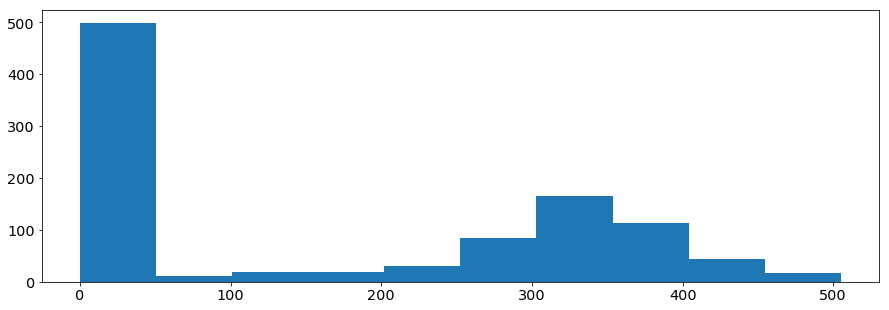

In [126]:
plt.hist([len(d) for d in data])
select = np.where(np.array([len(d) for d in data])>100)[0]
print(len(select))

In [127]:
hyper_select[0]

array([1.        , 5.        , 0.01474924, 0.        , 0.01051671,
       0.06850711, 0.02235248, 0.09772512])

In [128]:
winrate = []
for i in select:
    winrate.append(np.partition(np.array(data[i][:100]).flatten(), -10)[-10])
winrate = np.array(winrate)
hyper_select = hyper[select]
temp = np.zeros_like(hyper_select)
hyper_select[:,3] = np.array([float(i=='True') for i in hyper_select[:,3]])
hyper_select = hyper_select.astype(np.float)
param_name = np.array(['n_layer','log10(1-gamma)', 'epsilon decay', 'log10(epsilon)', 'Dropout', 'log10(win reward)', 'log10(points per turn reward)'])

In [129]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

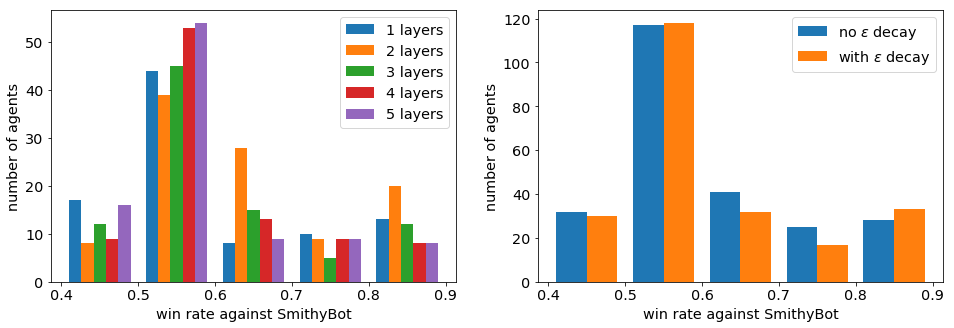

In [135]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
bins = np.arange(0.4, 1, 0.1)
plt.hist([0.01*winrate[np.array(np.asarray(hyper_select[:,1], dtype=float)==i)] for i in range(1,6)],bins=bins, histtype='bar', label=['{:d} layers'.format(i) for i in range(1,6)])
plt.legend()
plt.xlabel('win rate against SmithyBot')
plt.ylabel('number of agents')
plt.subplot(1,2,2)

bins = np.arange(0.4, 1, 0.1)
plt.hist([0.01*winrate[np.array(np.asarray(hyper_select[:,3], dtype=float)==i)] for i in range(2)],bins=bins, histtype='bar', label=['no $\epsilon$ decay','with $\epsilon$ decay'])
plt.legend()
plt.xlabel('win rate against SmithyBot')
plt.ylabel('number of agents')
plt.savefig('plots/N_layers_epsilon_decay_histogram.png')

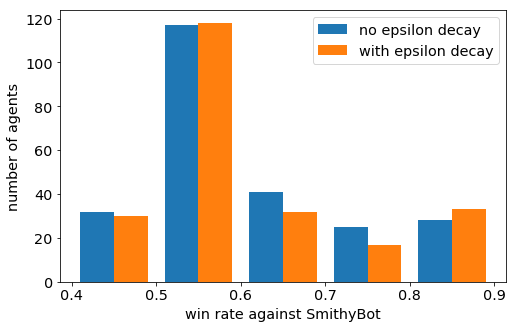

In [40]:
plt.figure(figsize=(8,5))
bins = np.arange(0.4, 1, 0.1)
plt.hist([0.01*winrate[np.array(np.asarray(hyper_select[:,3], dtype=float)==i)] for i in range(2)],bins=bins, histtype='bar', label=['no epsilon decay','with epsilon decay'])
plt.legend()
plt.xlabel('win rate against SmithyBot')
plt.ylabel('number of agents')
plt.savefig('plots/epsilon_decay.png')

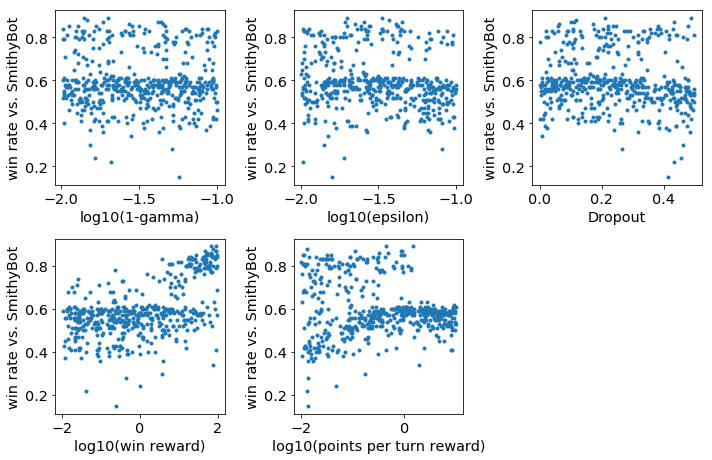

In [147]:
param_select = np.array([1,3,4,5,6])
fig = plt.figure(figsize=(10,6.5))
for i in range(len(param_select)):
    #ax = plt.subplot(2,3,i+1)
    ax = fig.add_subplot(2,3,i+1)
    if i==2:
        plt.plot(hyper_select[:,param_select+1][:,i], winrate/100, '.')
    else:
        plt.plot(np.log10(hyper_select[:,param_select+1][:,i]), winrate/100, '.')
    plt.xlabel(param_name[param_select][i])
    plt.ylabel('win rate vs. SmithyBot')
plt.tight_layout()
plt.savefig('plots/hyperparam_scatter.png')

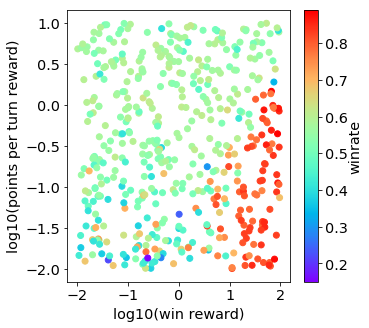

In [49]:
plt.figure(figsize=(5,5))
x = np.array(hyper_select[:,6], dtype=float)
y = np.array(hyper_select[:,7], dtype=float)
plt.scatter(np.log10(x),np.log10(y), c=winrate/100, cmap='rainbow')
plt.xlabel('log10(win reward)')
plt.ylabel('log10(points per turn reward)')

cbar= plt.colorbar()
cbar.set_label("winrate", labelpad=+1)
plt.savefig('plots/win_reward_ppt_scatter.png')

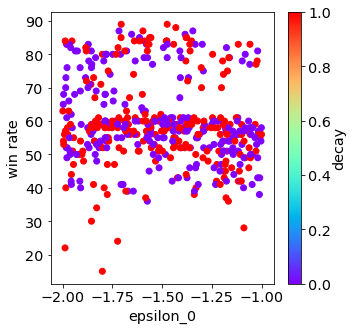

In [48]:
plt.figure(figsize=(5,5))
x = np.array(hyper_select[:,4], dtype=float)
y = winrate
plt.scatter(np.log10(x),y, c=np.array(hyper_select[:,3], dtype=float), cmap='rainbow')
plt.xlabel('epsilon_0')
plt.ylabel('win rate')

cbar= plt.colorbar()
cbar.set_label("decay", labelpad=+1)

# constant parameter
Evaluate convergence

In [50]:
import csv
import numpy as np
import matplotlib.pyplot as plt

data_path = 'constant_meta.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    hyper = np.array(data)

data_path = 'constant_data.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    data = np.array(data)
# discard first column of data
data = np.array([np.asarray(d[1:],dtype=float) for d in data])

In [63]:
data.shape

(100,)

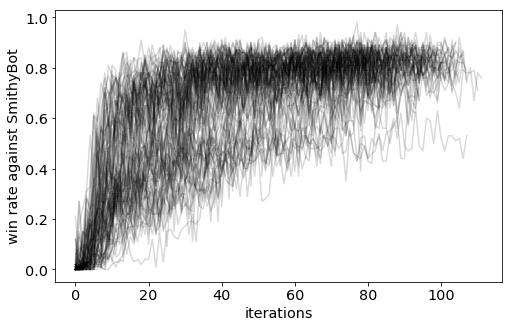

In [66]:
plt.figure(figsize=(8,5))
for i in range(len(data)):
    plt.plot(data[i]/100, alpha=0.15, c='k')
plt.xlabel('iterations')
plt.ylabel('win rate against SmithyBot')
plt.savefig('plots/convergence.png')

In [114]:
import csv
import numpy as np
import matplotlib.pyplot as plt

data_path = 'dql_sarsa_meta.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    hyper = np.array(data)

data_path = 'dql_sarsa_data.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    data = np.array(data)
# discard first column of data
data = np.array([np.asarray(d[1:],dtype=float) for d in data])

44


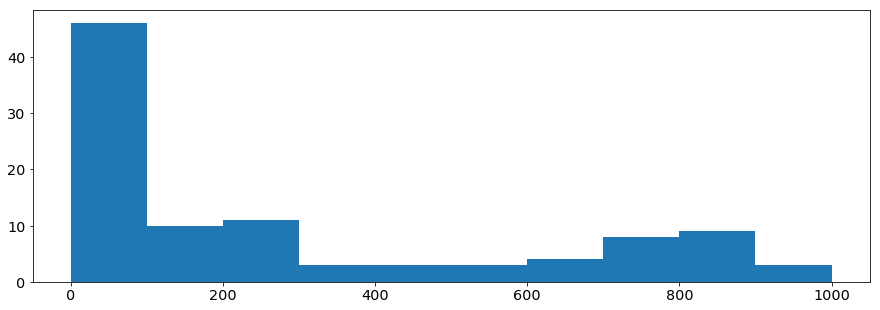

In [115]:
plt.hist([len(d) for d in data])
select = np.where(np.array([len(d) for d in data])>200)[0]
print(len(select))

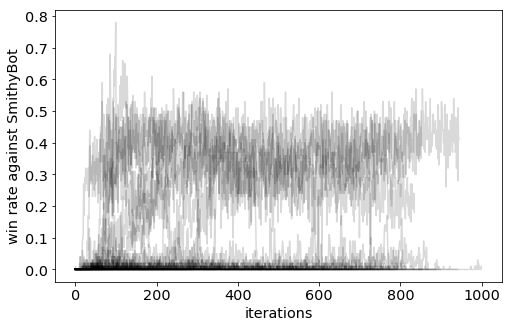

In [116]:
plt.figure(figsize=(8,5))
for i in range(len(data)):
    plt.plot(data[i]/100, alpha=0.15, c='k')
plt.xlabel('iterations')
plt.ylabel('win rate against SmithyBot')

In [123]:
winrate = []
for i in select:
    winrate.append(np.partition(np.array(data[i][100:]).flatten(), -5)[-5])
winrate = np.array(winrate)
hyper_select = hyper[select]
temp = np.zeros_like(hyper_select)
hyper_select[:,3] = np.array([float(i=='True') for i in hyper_select[:,3]])
hyper_select = hyper_select.astype(np.float)
param_name = np.array(['n_layer','log10(1-gamma)', 'epsilon decay', 'log10(epsilon)', 'Dropout', 'log10(win reward)', 'log10(points per turn reward)'])

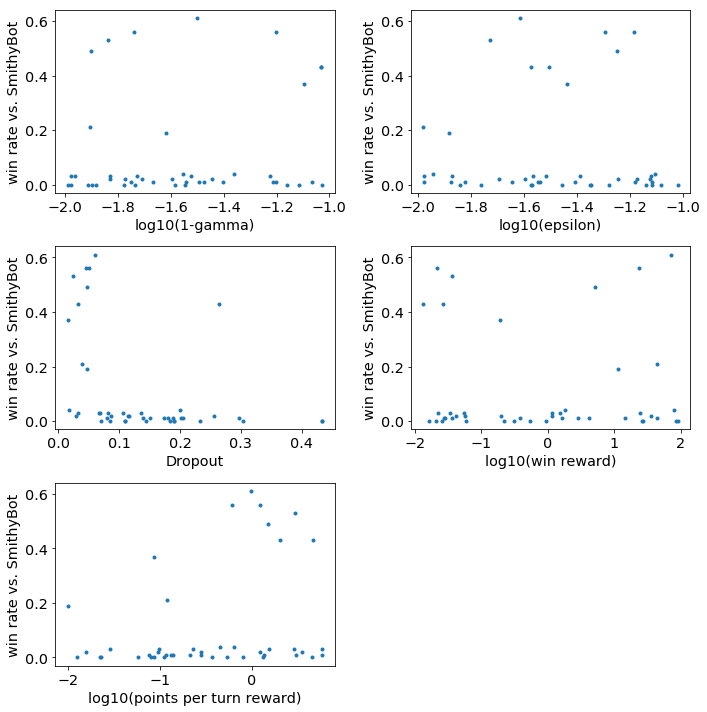

In [124]:
param_select = np.array([1,3,4,5,6])
plt.figure(figsize=(10,10))
for i in range(len(param_select)):
    plt.subplot(3,2,i+1)
    if i==2:
        plt.plot(hyper_select[:,param_select+1][:,i], winrate/100, '.')
    else:
        plt.plot(np.log10(hyper_select[:,param_select+1][:,i]), winrate/100, '.')
    plt.xlabel(param_name[param_select][i])
    plt.ylabel('win rate vs. SmithyBot')
plt.tight_layout()

# DQLSarsaAgent

In [90]:
import csv
import numpy as np
import matplotlib.pyplot as plt

data_path = 'dql_sarsa_meta.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    hyper = np.array(data)

data_path = 'dql_sarsa_data.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    data = np.array(data)
# discard first column of data
data = np.array([np.asarray(d[1:],dtype=float) for d in data])

In [92]:
def read_meta_data(fn):
    data_path = fn + '_meta.csv'
    with open(data_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        # get header from first row
        headers = next(reader)
        # get all the rows as a list
        data = list(reader)
        # transform data into numpy array
        hyper = np.array(data)

    data_path = fn + '_data.csv'
    with open(data_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        # get header from first row
        headers = next(reader)
        # get all the rows as a list
        data = list(reader)
        # transform data into numpy array
        data = np.array(data)
    # discard first column of data
    data = np.array([np.asarray(d[1:],dtype=float) for d in data])
    return hyper, data

In [93]:
h_mc, d_mc = read_meta_data('sarsa_agent')
h_sarsa, d_sarsa = read_meta_data('sarsa_on_policy')
h_dql, d_dql = read_meta_data('dql_sarsa')

In [ ]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)

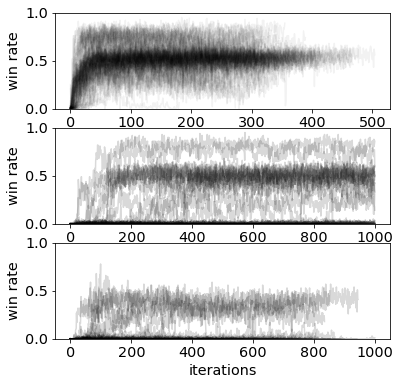

In [113]:
plt.figure(figsize=(6,6))
plt.subplot(3,1,1)
for i in range(len(data)):
    plt.plot(d_mc[i]/100, alpha=0.05, c='k')
plt.xlabel('iterations')
plt.ylabel('win rate')
plt.ylim([0,1])
plt.subplot(3,1,2)
for i in range(len(data)):
    plt.plot(d_sarsa[i]/100, alpha=0.15, c='k')
plt.xlabel('iterations')
plt.ylabel('win rate')
plt.ylim([0,1])
plt.subplot(3,1,3)
for i in range(len(data)):
    plt.plot(d_dql[i]/100, alpha=0.15, c='k')
plt.xlabel('iterations')
plt.ylabel('win rate')
plt.ylim([0,1])
plt.savefig('plots/algorithm_comparison.png')